# HW3：SMS 垃圾簡訊分類（End-to-End）

本筆記本示範：資料前處理 → 模型訓練與評估 → 視覺化 → 推論。每個程式碼區塊前提供繁體中文說明，並確保可以從頭執行完成。


## 匯入套件與環境設定
以下程式碼將匯入所需的 Python 套件，並設定亂數種子以利結果重現。


In [133]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)
from sklearn.model_selection import train_test_split

# 環境設定
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# 路徑設定（可依需求調整）
RAW_CSV = 'sms_spam_no_header.csv'     # 若無原始檔可留空或跳過前處理步驟
CLEAN_CSV = 'sms_spam_clean.csv'       # 你當前專案中已有此檔
MODEL_DIR = 'model_artifacts'          # 你當前專案中已有此資料夾
TEXT_COL = 'text'
LABEL_COL = 'label'


## 資料載入與（可選）前處理
若已具備清理後資料 `sms_spam_clean.csv`，可直接載入。若尚未生成，可執行前處理腳本產生該檔案。


In [134]:
# 若清理後資料不存在，且有原始檔，則嘗試以 CLI 方式執行前處理
if not os.path.exists(CLEAN_CSV) and os.path.exists(RAW_CSV):
    import subprocess
    print('清理後資料不存在，嘗試執行 preprocessing.py...')
    cmd = [
        'python', 'preprocessing.py',
        '--input_csv', RAW_CSV,
        '--output_csv', CLEAN_CSV,
        '--text_column', TEXT_COL,
        '--label_column', LABEL_COL,
        '--no_header'
    ]
    subprocess.run(cmd, check=True)

# 載入清理後資料
if not os.path.exists(CLEAN_CSV):
    raise FileNotFoundError(f'無法找到清理後資料: {CLEAN_CSV}. 請先產生或調整路徑設定。')

df = pd.read_csv(CLEAN_CSV)
print(df.head())
print(df[LABEL_COL].value_counts())


   label                                               text
0      0  jurong point crazy available bugis n great wor...
1      0                            ok lar joking wif u oni
2      1  free entry wkly comp win fa cup final tkts st ...
3      0                        u dun say early hor u c say
4      0                     nah don t think goes usf lives
label
0    4827
1     747
Name: count, dtype: int64


## 資料集概覽與類別分佈
我們先檢視資料筆數、欄位與類別（spam/ham）分佈，以了解資料平衡情況。


資料筆數: 5574
欄位: ['label', 'text']


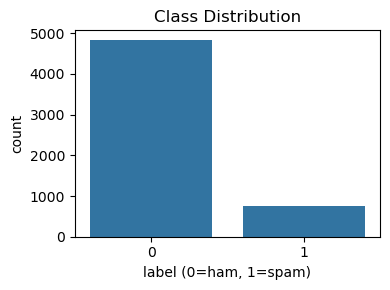

In [135]:
print('資料筆數:', len(df))
print('欄位:', list(df.columns))

plt.figure(figsize=(4,3))
sns.countplot(x=df[LABEL_COL])
plt.title('Class Distribution')
plt.xlabel('label (0=ham, 1=spam)')
plt.ylabel('count')
plt.tight_layout()
plt.show()


## 模型訓練與評估（TF‑IDF + Logistic Regression）
此步驟將資料切分為訓練/測試集，使用 TF‑IDF 特徵與邏輯斯回歸訓練模型，並計算 Accuracy、Precision、Recall、F1、混淆矩陣。


In [136]:
# 資料切分
X = df[TEXT_COL].astype(str)
y = df[LABEL_COL].astype(int)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# 向量化 + 訓練
vectorizer = TfidfVectorizer(max_features=20000, stop_words='english')
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

model = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)
model.fit(X_train_vec, y_train)

y_pred = model.predict(X_test_vec)
y_prob = model.predict_proba(X_test_vec)[:, 1]

metrics = {
    'accuracy': float(accuracy_score(y_test, y_pred)),
    'precision': float(precision_score(y_test, y_pred, zero_division=0)),
    'recall': float(recall_score(y_test, y_pred, zero_division=0)),
    'f1': float(f1_score(y_test, y_pred, zero_division=0)),
    'confusion_matrix': confusion_matrix(y_test, y_pred).tolist(),
}
metrics


{'accuracy': 0.9713004484304932,
 'precision': 0.9915966386554622,
 'recall': 0.7919463087248322,
 'f1': 0.8805970149253731,
 'confusion_matrix': [[965, 1], [31, 118]]}

## 混淆矩陣、ROC 與 PR 曲線
以下繪製模型預測表現的圖表，協助理解分類品質與閾值行為。


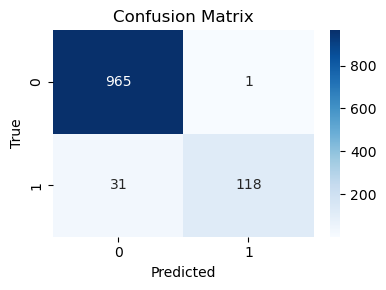

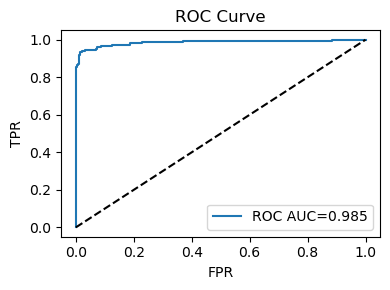

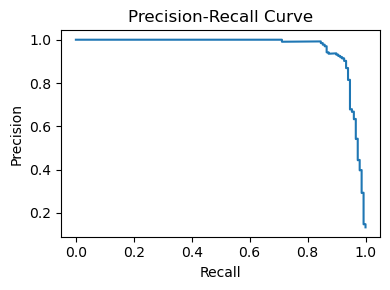

In [137]:
# 混淆矩陣
cm = np.array(metrics['confusion_matrix'])
plt.figure(figsize=(4,3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.tight_layout()
plt.show()

# ROC 曲線
fpr, tpr, roc_thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(4,3))
plt.plot(fpr, tpr, label=f'ROC AUC={roc_auc:.3f}')
plt.plot([0,1],[0,1],'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC Curve')
plt.legend()
plt.tight_layout()
plt.show()

# Precision-Recall 曲線
prec, rec, pr_thresholds = precision_recall_curve(y_test, y_prob)
plt.figure(figsize=(4,3))
plt.plot(rec, prec)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.tight_layout()
plt.show()


## 閾值（Threshold）掃描
我們掃描 0–1 閾值，計算 Precision/Recall/F1 以觀察權衡關係，協助選擇決策閾值。


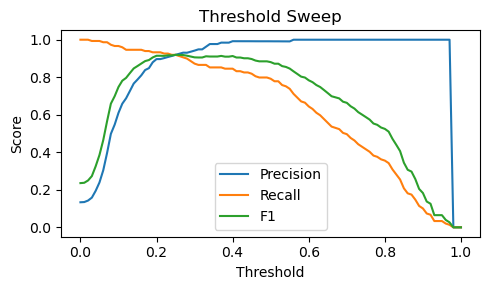

In [138]:
# 閾值掃描：計算不同 threshold 下的 Precision/Recall/F1
thresholds = np.linspace(0, 1, 101)
precisions, recalls, f1s = [], [], []
for th in thresholds:
    preds = (y_prob >= th).astype(int)
    precisions.append(precision_score(y_test, preds, zero_division=0))
    recalls.append(recall_score(y_test, preds, zero_division=0))
    f1s.append(f1_score(y_test, preds, zero_division=0))

plt.figure(figsize=(5,3))
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.plot(thresholds, f1s, label='F1')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Threshold Sweep')
plt.legend()
plt.tight_layout()
plt.show()


## 儲存模型與向量器
將訓練好的模型與 TF‑IDF 向量器儲存至 `model_artifacts/`，方便後續推論或部署使用。


In [139]:
import joblib
os.makedirs(MODEL_DIR, exist_ok=True)
joblib.dump(model, os.path.join(MODEL_DIR, 'model.joblib'))
joblib.dump(vectorizer, os.path.join(MODEL_DIR, 'vectorizer.joblib'))
with open(os.path.join(MODEL_DIR, 'metrics.json'), 'w', encoding='utf-8') as f:
    json.dump(metrics, f, indent=2, ensure_ascii=False)
print('Artifacts saved to', MODEL_DIR)


Artifacts saved to model_artifacts


## 推論範例
以一段自訂訊息測試垃圾訊息機率與分類結果。


In [140]:
sample_text = "WINNER!! You have won a free ticket"
X_demo = vectorizer.transform([sample_text])
prob_spam = float(model.predict_proba(X_demo)[0, 1])
pred = int(prob_spam >= 0.5)
print('text:', sample_text)
print('spam_probability=', prob_spam)
print('prediction=', pred)


text: WINNER!! You have won a free ticket
spam_probability= 0.5150974061142589
prediction= 1


## 提升 Recall 的策略
- 調整決策閾值（降低 threshold 以提高召回率）
- 使用 `class_weight='balanced'` 重新訓練模型，偏向召回少數類別


In [141]:
# 範例：選擇達成目標召回率的 threshold（例如 >= 0.95）
from bisect import bisect_left

def threshold_for_target_recall(y_true, y_scores, target=0.95):
    prec, rec, ths = precision_recall_curve(y_true, y_scores)
    # precision_recall_curve returns thresholds for points except the first
    # Align recall(threshold) by scanning from high recall to low
    best_th = 0.5
    for r, t in zip(rec[1:], ths):
        if r >= target:
            best_th = float(t)
        else:
            break
    return best_th

target_recall = 0.85
th_opt = threshold_for_target_recall(y_test, y_prob, target=target_recall)
print('target_recall =', target_recall)
print('chosen_threshold =', th_opt)

preds_opt = (y_prob >= th_opt).astype(int)
metrics_opt = {
    'accuracy': float(accuracy_score(y_test, preds_opt)),
    'precision': float(precision_score(y_test, preds_opt, zero_division=0)),
    'recall': float(recall_score(y_test, preds_opt, zero_division=0)),
    'f1': float(f1_score(y_test, preds_opt, zero_division=0)),
}
metrics_opt


target_recall = 0.85
chosen_threshold = 0.3675250993667687


{'accuracy': 0.9775784753363229,
 'precision': 0.9769230769230769,
 'recall': 0.8523489932885906,
 'f1': 0.910394265232975}

## 分類報告（Classification Report）
以下列印分類報告，包含 Precision / Recall / F1。先以預設閾值 0.5，再以前述最佳閾值（若已計算）。


In [142]:
from sklearn.metrics import classification_report

print('Summary (threshold=0.4):')
preds_05 = (y_prob >= 0.4).astype(int)
print(classification_report(y_test, preds_05, digits=4))

# 若先前已計算最佳閾值 th_opt，則同時列印
if 'th_opt' in globals():
    print('\nSummary (threshold=th_opt=%.4f):' % th_opt)
    preds_opt = (y_prob >= th_opt).astype(int)
    print(classification_report(y_test, preds_opt, digits=4))



Summary (threshold=0.4):
              precision    recall  f1-score   support

           0     0.9767    0.9990    0.9877       966
           1     0.9921    0.8456    0.9130       149

    accuracy                         0.9785      1115
   macro avg     0.9844    0.9223    0.9504      1115
weighted avg     0.9788    0.9785    0.9777      1115


Summary (threshold=th_opt=0.3675):
              precision    recall  f1-score   support

           0     0.9777    0.9969    0.9872       966
           1     0.9769    0.8523    0.9104       149

    accuracy                         0.9776      1115
   macro avg     0.9773    0.9246    0.9488      1115
weighted avg     0.9776    0.9776    0.9769      1115

